Author: Hongyi Su, M.Sc.(Geophysics) candidate at LMU München & TUM, Germany

hsu@geophysik.uni-muenchen.de

In [12]:
import obspy
from obspy import UTCDateTime
import numpy as np
from obspy.core.inventory import Station, Channel, Site
import matplotlib.pyplot as plt
import os
import Waveform
import re
from obspy.clients.fdsn import Client
from scipy.io import savemat #for save obspy object as matlab format

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 4
plt.rcParams['lines.linewidth'] = 0.5

In [3]:
def read(fileName):
  data = []
  coordinates = [float('nan')] * 3
  coordComment = re.compile('#\s*x(\d)\s+([0-9\.eE\+\-]+)')
  variables = ''
  p_0 = 0.
  t_s = 0.
  t_d = 0.
  f = open(fileName)
  for row in f:
    row = row.strip()
    if not row[0].isalpha() and not row[0] == '#':
      values = row.split()
      data.append([float(numeric_string) for numeric_string in values])
    elif row[0] == '#':
      match = coordComment.match(row)
      if match:
        coordinates[int(match.group(1))-1] = float(match.group(2))
      elif row[2:5] == 'P_0':
        p_0 = float(row[5:])
      elif row[2:5] == 'T_s':
        t_s = float(row[5:])
      elif row[2:5] == 'T_d':
        t_d = float(row[5:])
    elif row.startswith('VARIABLES'):
      row = row.split('=')
      variables = row[1].replace('"', '').split(',')
      variables = [v.strip() for v in variables]
  f.close()
  if len(data) == 0:
    return None
  if 'P_n' in variables:
    indexP_n = variables.index('P_n')
    data = [d[0:indexP_n] + [d[indexP_n] + p_0] + d[indexP_n+1:] for d in data]
  if 'T_s' in variables:
    indexT_s = variables.index('T_s')
    data = [d[0:indexT_s] + [d[indexT_s] + t_s] + d[indexT_s+1:] for d in data]
  if 'T_d' in variables:
    indexT_d = variables.index('T_d')
    data = [d[0:indexT_d] + [d[indexT_d] + t_d] + d[indexT_d+1:] for d in data]
  return Waveform.Waveform(variables, data, coordinates)

Simulation Data

In [6]:
wave = read('botswana_model_case2-receiver-00001-00008.dat') 
w = wave.waveforms['w']
v = wave.waveforms['v']
u = wave.waveforms['u']
t_w = wave.time

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       4.89654511e-10, 4.91050962e-10, 4.85485321e-10])

In [10]:
wave.coordinates #NE208

array([29078.76494 , 81388.609365,     0.      ])

In [14]:
#2017-4-3T17:40:18
t = UTCDateTime(2017, 4, 3, 17, 40, 18) #main shock

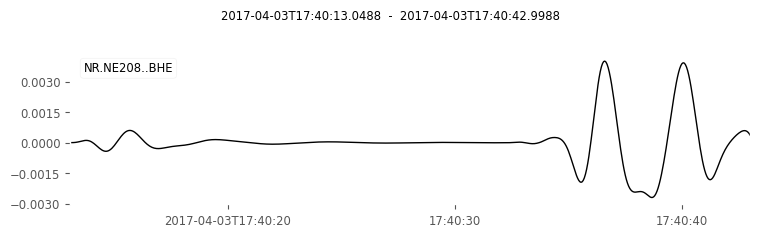

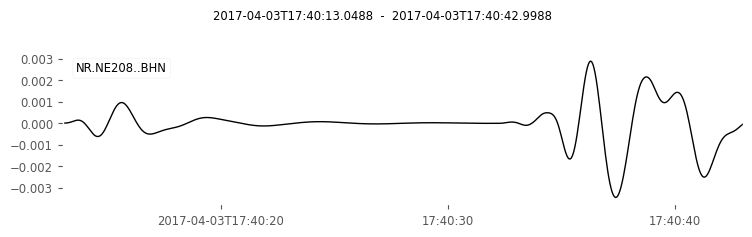

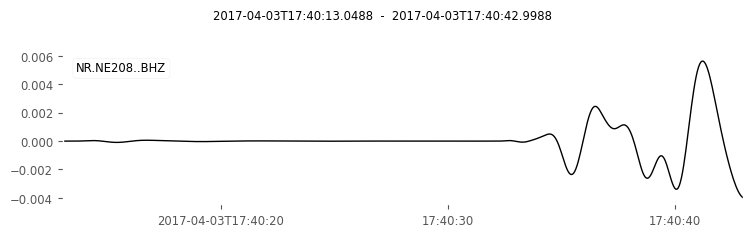

In [53]:
#plot obs vertical 
client = Client("IRIS")
sta = "NE208"
ew = client.get_waveforms("NR", sta, "", "BHE", t-5, t+30)
ns = client.get_waveforms("NR", sta, "", "BHN", t-5, t+30)
ver = client.get_waveforms("NR", sta, "", "BHZ", t-5, t+30)



#ver.plot();#Plot RAW data
inv_ver = client.get_stations(network="NR", station=sta, location="", channel="BHZ",
                     starttime=t-5, endtime=t+30, level="response")
inv_ew = client.get_stations(network="NR", station=sta, location="", channel="BHE",
                     starttime=t-5, endtime=t+30, level="response")
inv_ns = client.get_stations(network="NR", station=sta, location="", channel="BHN",
                     starttime=t-5, endtime=t+30, level="response")
#instrument removed + filter
ew = ew.slice(endtime=t+25).copy().remove_response(inventory=inv_ew, output="Vel").filter("bandpass", 
freqmin=0.2, freqmax=0.6, corners=4)
ew.plot();

ns = ns.slice(endtime=t+25).copy().remove_response(inventory=inv_ns, output="Vel").filter("bandpass", 
freqmin=0.2, freqmax=0.6, corners=4).plot();

ver = ver.slice(endtime=t+25).copy().remove_response(inventory=inv_ver, output="Vel").filter("bandpass", 
freqmin=0.2, freqmax=0.6, corners=4).plot();


## In the following cell, save processed data and plot it in matlab

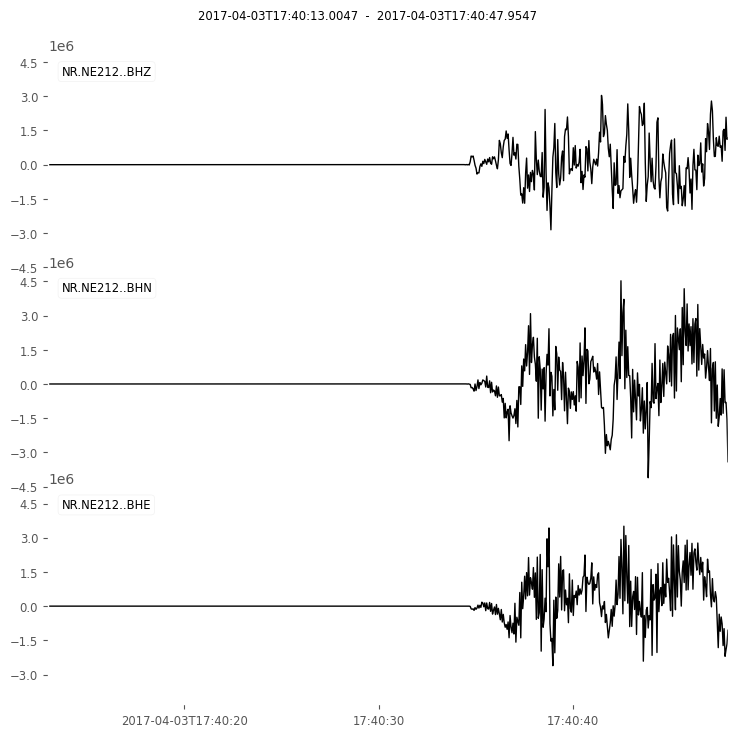

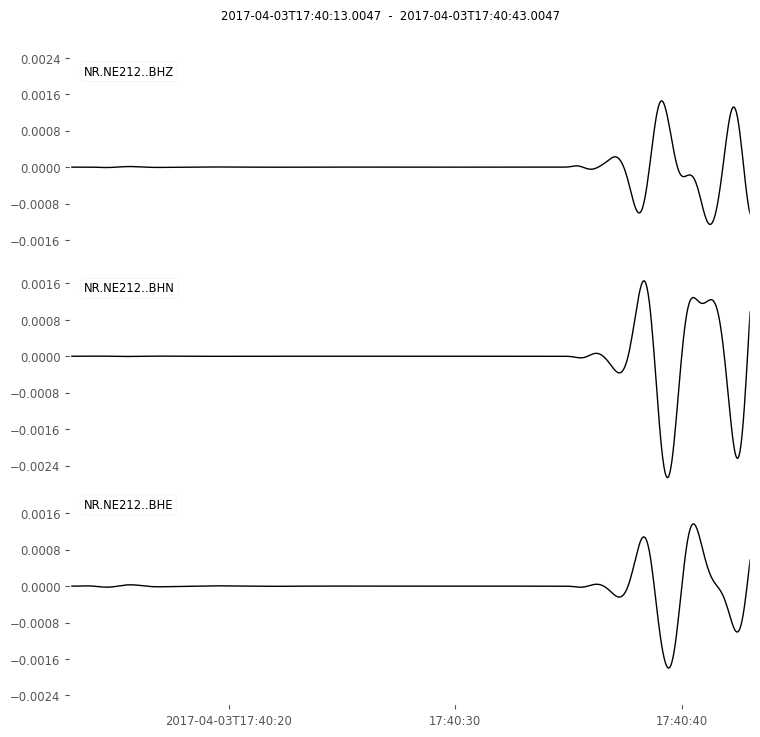

In [56]:
sta="NE212"
st = client.get_waveforms("NR", sta, "", "BH?", t-5, t+30)
st.plot();#Plot RAW data
inv = client.get_stations(network="NR", station=sta, location="", channel="BH?",starttime=t-5, endtime=t+30, level="response")
#instrument removed + filter + VEL
trace = st.slice(endtime=t+25).copy().remove_response(inventory=inv, output="VEL").filter("bandpass", 
freqmin=0.2, freqmax=0.6, corners=4);
trace.plot()

for i, tr in enumerate(trace):
    mdict = {k: str(v) for k, v in tr.stats.items()} #change iteritems to items
    mdict['data'] = tr.data
    savemat("data-" + str(sta) + "_new_" + str(i) +".mat", mdict) #change like this

## Plot observational and synthetic waveform together

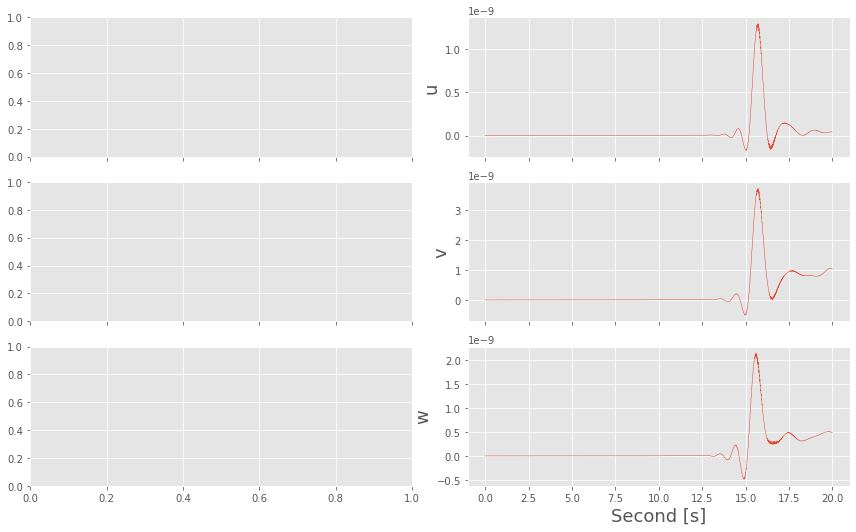

In [51]:
fig, axs = plt.subplots(3, 2, sharex='col',figsize = (12,12/1.6))





axs[0,1].plot(t_w, u)
#axs[0,1].set_title(str("sim_" + station_list[0]+".bbp"), fontsize=18)
axs[0,1].set_ylabel("u", fontsize=18)
axs[1,1].plot(t_w, v)
axs[1,1].set_ylabel("v", fontsize=18)

axs[2,1].plot(t_w, w)
axs[2,1].set_ylabel("w", fontsize=18)
axs[2,1].set_xlabel("Second [s]", fontsize=18)


fig.tight_layout()
#fig.savefig(os.path.join(my_path, my_file))  